In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
import random
import math, statistics
import numpy as np
from scipy.spatial import distance

In [2]:
class CaseAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, initial_wealth=10):
        super().__init__(unique_id, model)
        self.wealth = initial_wealth
        self.alt_wealth_calculation=0
        self.original_wealth=self.wealth
        self.memory = []
        self.action = 0
        self.result=0
        self.cases = []
        self.deflator_cases = []
        self.circumstances = []
        self.action_set=[0.25, 0.5, 0.75]
        
    def get_circumstance(self):
        if len(model.realized_interest_rate_list) <=2:
            p_2 = random.choice(range(0,1))
            p_1 = 1                  
            new_circumstance = (p_2-p_1)/p_1
        else:
            new_circumstance =  (model.realized_interest_rate_list[-1]- model.realized_interest_rate_list[-2])/model.realized_interest_rate_list[-2]
        return new_circumstance
        print( "new circumstance is", new_circumstance, ".")
        
    def get_wealth(self):
        wealth = self.wealth
        return wealth
    
    def choose_action(self):
        if not self.cases:
            choice = random.choice(self.action_set)
            
        else:
            best_choice = self.evaluate_actions()    
            choice=random.choice(best_choice)
        return choice    
         
    
    def evaluate_actions(self):                  #evaluate all the actions and choose the one which has highest CBU
        cbu_list = list()
        for action in self.action_set:
            all_action_cbu = []
            new = np.array([action,self.get_circumstance()])
                
           
            for case in self.deflator_cases: #<--- looping through memory for each action, accumulate data in all_action_cbu    
                old =np.array([case["action"], case["circumstance"]])
                if abs(action-case["action"]) > model.B/2: #<--- do not consider this case, out of bandwidth
                    pass # you don't need to do anything here
                    
                else: #<--- consider this case and add to all_action_cbu
                    similarity =1/math.exp(distance.euclidean(new,old))
                    single_case_cbu = similarity*(case["result"] - model.H)
                    all_action_cbu.append(single_case_cbu)
             
            # Now, we have gone through all memory, and evaluate it for this action
            if len(all_action_cbu) == 0 : # I have found NO relevant cases in memory (TODO: CHECK CODE)
                cbu = 0
            else: # I have found at least one relevant case
                cbu = sum(all_action_cbu)

            act_value = {"action":action, "value":cbu}
            cbu_list.append(act_value)
            # now we have act_value for this action
   
        best_value = max(cbu_list, key=(lambda x: x["value"]))
        #print("best_value is ",best_value)
        best_choices= []
    
      

        for act_value in cbu_list:
            if act_value["value"] == best_value["value"]:
                best_choices.append(act_value["action"])
                
        return best_choices
        print(best_choices,".")            
    
    def get_flow_utility(self):
        consumption = self.wealth*self.action
        flow_utility = math.log(consumption)   #calculate each agent's payoff
        return flow_utility
        
    #def get_continuation_utility(self):
    
    def update_case(self):
        values = i.cases.values()
        values_list = list(values)
        i.cases[k]["result"]=i.cases
        return cases
    
    def print(self):
        print("agent: ", self.unique_id, " wealth: ", self.wealth," original_wealth: ", self.original_wealth, 
              " alt wealth: ", self.alt_wealth_calculation , "ratio:", self.original_wealth / self.alt_wealth_calculation )
        

In [37]:
class CaseModel(Model):
    """A model with some number of agents."""
    def __init__(self, N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=.5, K0=None, initial_wealth=10, use_alt_wealth=False
                 , verbose=False):#(50,0.1,10,0.90,1,0.33,None,0.5)
        self.num_agents = N
        # Create agents
        self.schedule = RandomActivation(self)
        self.actions=[]
        self.all_capital = []
        self.all_consumption = []
        if K0 is not None:
            self.total_K = K0
        else:
            self.total_K = N * initial_wealth
        self.consumption_list = []
        self.capital_list = []
        self.total_C = 0
        self.results=[]
        self.wealths=[]
        
        self.verbose=verbose
        
        self.use_alt_wealth = use_alt_wealth
        
        self.realized_interest_rate = 0
        self.realized_interest_rate_list = []
        self.real_wage = 0
        self.real_wage_list = []
        self.total_output=0
        self.output_list = []
        self.agents=[] #ADP: have an agents vector directly in Model.
        self.tick=0    #ADP: keep track of time.
        self.H = H
        self.B = Bandwidth
        self.beta = beta
        self.action_set=[0.25, 0.5, 0.75]
        self.z = z
        self.alpha = alpha
        self.deflator=deflator
        self.delta=delta
          # Create agents
        for i in range(self.num_agents):
            a = CaseAgent(i, self, initial_wealth)
            self.schedule.add(a)
            self.agents.append(a)
        self.datacollector = DataCollector(
            model_reporters={"interest_rate": "realized_interest_rate",
                             "real_wage":"real_wage",
                            'GDP':"last_output", #'GDP':"total_output",
                             "capital":"total_K",
                            "consumption":"total_C"},
            agent_reporters={"Wealth": "wealth", "Result": "result", "Action": "action", "Cases":"cases"})
        
    def reset(self):
        self.actions = []
        self.all_capital=[]
        self.all_consumption=[]
        self.results = []
        
    def calculate_price(self):
        total_K=sum(self.all_capital)
        realized_interest_rate =self.z*self.alpha*(total_K**(self.alpha-1))
        
        if self.use_alt_wealth:
            realized_interest_rate = self.total_output / self.total_K - 1
        
        return realized_interest_rate
    
    def calculate_wage(self):
        total_K=sum(self.all_capital)
        real_wage =self.z*(1-self.alpha)*(total_K**self.alpha)
        return real_wage
    
    def get_output(self):
        total_K=sum(self.all_capital)
        total_output =self.z*(total_K**(self.alpha))
        return total_output
    
    def get_consumption(self):
        total_C=sum(self.all_consumption)
        return total_C
    
    def get_capital(self):
        total_K=sum(self.all_capital)
        return total_K
    
    def update_H(self):
        self.H = (self.H)*self.beta
        return self.H
    
    def initialize(self):
        
        for i in self.agents:
            i.action = random.choice(self.action_set)
            self.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            self.all_capital.append(i.current_capital)
        #print( "actions:", self.actions, ".") 
        #print( "all capital", self.all_capital, ".") 
        
    def step(self):
        '''Advance the model by one step.'''
        
        
        #self.schedule.step()
        
        
        self.reset() # this sets up the turn
        self.tick += 1 # ADP: iterate time.
        #previous_price = self.calculate_price()
        
        #save lags
        self.last_total_K = self.total_K
        self.last_output = self.total_output
        
        for i in self.agents:
            # loop where agents choose
            
            self.H = self.update_H()
            i.new_circumstance = i.get_circumstance()  #observe new circumstance
            
            #i.wealth = i.get_wealth()
            #print( "new circumstance:", i.new_circumstance, ".") 
            
            i.action = i.choose_action()
            #print( "choices:", i.evaluate_actions, ".") 
            #agents make predictions for each round "action"
           
            self.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            i.current_consumption = i.wealth*i.action
            
            self.all_capital.append(i.current_capital)
            self.all_consumption.append(i.current_consumption)
            
        
        #print("all past prices are:", self.realized_interest_rate_list)
        
        
        #
        self.realized_interest_rate = self.calculate_price() # must be based on current action
        
        
        self.real_wage = self.calculate_wage()        
        self.realized_interest_rate_list.append(self.realized_interest_rate)
        self.real_wage_list.append(self.real_wage)
        self.total_output = self.get_output()  
        self.output_list.append(self.total_output)
        self.total_C = self.get_consumption()
        self.total_K = self.get_capital()
        self.consumption_list.append(self.total_C)
        self.capital_list.append(self.total_K)
        if self.verbose:
            print( "price:", self.realized_interest_rate, ".") #model calculate the market price  "circumstance"

        
        
        for i in self.agents: 
            # loop where they get their payoffs
            
            i.result = i.get_flow_utility()                 #agents get their payoff for each round  "result"
            self.results.append(i.result)
            
            i.new_case = {"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.cases.append(i.new_case)
          
            i.deflator_case={"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.deflator_cases.append(i.deflator_case)
            for index in range(len(i.deflator_cases)):
                length=len(i.deflator_cases)
                i.deflator_cases[index]["result"]=i.deflator_cases[index]["result"]+self.delta**(length-index)*i.result
                
            #i.update_case()
            #print(i.cases[:3]) 
      
           
            #i.actions_chosen.append(i.prediction)
            i.wealth = i.current_capital*(1+self.realized_interest_rate)            #next period goods
            i.original_wealth=i.wealth
            
            i.alt_wealth_calculation= self.total_output * ( i.current_capital / self.total_K ) #<--- actual return
            
                # ( i.current_capital / self.total_K ) = my fraction of the capital I own.
                # total_K = not based on current output. 
            
            if self.use_alt_wealth:
                i.wealth=i.alt_wealth_calculation
            
        self.datacollector.collect(self)    
       
        
        if self.verbose:
            print( "Time:", self.tick, ".") 
        #print( "Model_choices:", self.actions, ".")  
        #print( "Model_results:", self.results, ".")
      
       
         
    def print(self): 
        # ADP: Give every object a "print" function.
     
        print( "my__prediction", self.actions, ".")
        print( "realized_price", self.realized_interest_rate, ".")
        
        for i in self.agents:
            i.print()

In [5]:
model = CaseModel(N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=.5,use_alt_wealth=True)

model.initialize()
for i in range(50):
    model.step()    

    #model.print()
import matplotlib.pyplot as plt



# For jupyter notebook add the following line:
%matplotlib inline
all_data = model.datacollector.get_model_vars_dataframe()


price: -1.0 .
Time: 1 .
price: -0.9754254896198146 .
Time: 2 .
price: -0.5839130409116114 .
Time: 3 .
price: 0.46497489260976566 .
Time: 4 .
price: 1.0029941528039465 .
Time: 5 .
price: 1.510307593583772 .
Time: 6 .
price: 1.2851689953946566 .
Time: 7 .
price: 0.9056415506162656 .
Time: 8 .
price: 1.0223762481945111 .
Time: 9 .
price: 1.857932884117636 .
Time: 10 .
price: 0.94326031875351 .
Time: 11 .
price: 1.2416612559596358 .
Time: 12 .
price: 1.730747912029222 .
Time: 13 .
price: 0.8591780461537653 .
Time: 14 .
price: 1.1464145467514077 .
Time: 15 .
price: 1.691900505121143 .
Time: 16 .
price: 1.3425273633855772 .
Time: 17 .
price: 0.8298541295802104 .
Time: 18 .
price: 1.5538239190040546 .
Time: 19 .
price: 0.7668674983472112 .
Time: 20 .
price: 1.1723613908207322 .
Time: 21 .
price: 1.6196594111634717 .
Time: 22 .
price: 1.5388707964104609 .
Time: 23 .
price: 0.9300352374912662 .
Time: 24 .
price: 1.888584492232666 .
Time: 25 .
price: 0.7634480219830699 .
Time: 26 .
price: 1.0384

In [9]:
all_data[1:2]

,interest_rate,real_wage,GDP,capital,consumption
1,-0.975425,1.031908,6.205064,3.701536,2.503528


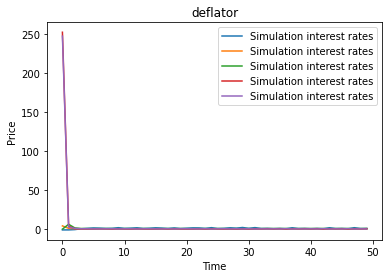

In [6]:
plt.figure()

plt.plot(all_data,label="Simulation interest rates")


plt.xlabel("Time")
plt.ylabel("Price")
plt.title("deflator")
#
plt.legend()

#model.datacollector.get_agent_vars_dataframe()

#plt.figure()
plt.savefig('deflator.png')

In [16]:
all_data.columns

Index(['interest_rate', 'real_wage', 'GDP', 'capital', 'consumption'], dtype='object')

In [21]:
def figfromdat(dat=None,name="default"):
    plt.figure()

    somedata=dat[10:50]
    plt.plot(somedata, label=somedata.columns)


    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("deflator")
    #
    plt.legend()

    #model.datacollector.get_agent_vars_dataframe()

    #plt.figure()
    plt.savefig(name+'deflator.png')


In [26]:
modelNoDefl = CaseModel(N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=0,use_alt_wealth=True)

modelNoDefl.initialize()
for i in range(50):
    modelNoDefl.step()    
    
data_NoDefl = modelNoDefl.datacollector.get_model_vars_dataframe()

price: -1.0 .
Time: 1 .
price: -0.9745751459795479 .
Time: 2 .
price: -0.5568077187918805 .
Time: 3 .
price: 0.29087261279599486 .
Time: 4 .
price: 1.1135177723553769 .
Time: 5 .
price: 0.9059383198983755 .
Time: 6 .
price: 1.5331029238936766 .
Time: 7 .
price: 1.5022414340452022 .
Time: 8 .
price: 1.3154021583057225 .
Time: 9 .
price: 1.5291097417382353 .
Time: 10 .
price: 1.1610729615111506 .
Time: 11 .
price: 1.0648528536446116 .
Time: 12 .
price: 1.6116022118733189 .
Time: 13 .
price: 1.0366516129459824 .
Time: 14 .
price: 1.3703104486057502 .
Time: 15 .
price: 1.4664011168848883 .
Time: 16 .
price: 1.52258390476926 .
Time: 17 .
price: 1.3450767080553874 .
Time: 18 .
price: 0.9994865048116237 .
Time: 19 .
price: 2.001683900507993 .
Time: 20 .
price: 1.1398696983420846 .
Time: 21 .
price: 0.874167756632098 .
Time: 22 .
price: 1.7680153893906483 .
Time: 23 .
price: 1.0833992266573187 .
Time: 24 .
price: 1.9354113011740703 .
Time: 25 .
price: 1.0313233996988038 .
Time: 26 .
price: 1.4

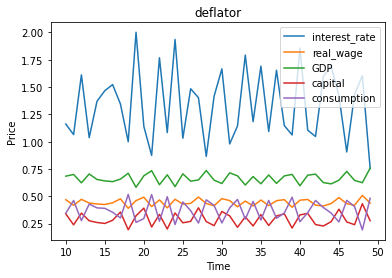

In [27]:
figfromdat(dat=data_NoDefl,name="NoDefl")

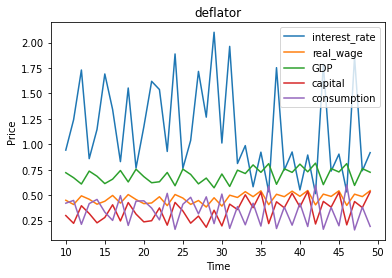

In [28]:
figfromdat(dat=all_data,name="Defl")

In [19]:
model.print()

my__prediction [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25] .
realized_price 0.9092838280825202 .
agent:  0  wealth:  0.0006666310882321093  original_wealth:  0.0008470176462656737  alt wealth:  0.0006666310882321093 ratio: 1.2705942780315653
agent:  1  wealth:  2.9700010927338554e-08  original_wealth:  3.773666394175133e-08  alt wealth:  2.9700010927338554e-08 ratio: 1.2705942780315653
agent:  2  wealth:  0.04266438964685495  original_wealth:  0.05420912936100305  alt wealth:  0.04266438964685495 ratio: 1.270594278031565
agent:  3  wealth:  0.02844292643123667  original_wealth:  0.03613941957400209  alt wealth:  0.02844292643123667 ratio: 1.2705942780315653
agent:  4  wealth:  0.02844292643123667  original_wealth:  0.03613941957400209  alt wealth

In [133]:
model.step()
model.print()

price: 1.8252781590280804 .
Time: 51 .
my__prediction [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75] .
realized_price 1.8252781590280804 .
agent:  0  wealth:  0.0014357408338272  original_wealth:  0.0011941734034940825  alt wealth:  0.0014357408338272 ratio: 0.8317471895751685
agent:  1  wealth:  0.029073751885000793  original_wealth:  0.024182011420755167  alt wealth:  0.029073751885000793 ratio: 0.8317471895751685
agent:  2  wealth:  0.001615208438055602  original_wealth:  0.0013434450789308445  alt wealth:  0.001615208438055602 ratio: 0.8317471895751685
agent:  3  wealth:  0.011485926670617595  original_wealth:  0.009553387227952655  alt wealth:  0.011485926670617595 ratio: 0.8317471895751684
agent:  4  wealth:  0.001615208438055602 

In [134]:
import statistics as stat
import numpy as np
model.datacollector.get_agent_vars_dataframe()
data1 = model.datacollector.get_model_vars_dataframe()
data = data1[25:200]
gdp = data["GDP"]
consumption = data["consumption"]
wage = data["real_wage"]
capital = data["capital"]
i = data["interest_rate"]
data

#plt.plot(model.datacollector.get_agent_vars_dataframe())

,interest_rate,real_wage,GDP,capital,consumption
25,0.647104,0.476143,0.782090,0.355217,0.426873
26,1.000641,0.413244,0.710662,0.231225,0.479437
27,1.667453,0.418903,0.616782,0.240955,0.375826
28,1.594792,0.406263,0.625229,0.219591,0.405638
29,1.761331,0.419541,0.606363,0.242068,0.364295
30,1.586796,0.430969,0.626180,0.262607,0.363573
31,1.449431,0.491626,0.643237,0.391387,0.251849
32,0.874793,0.452627,0.733771,0.304674,0.429096
33,1.217328,0.515493,0.675563,0.451849,0.223714
34,0.702764,0.430223,0.769392,0.261232,0.508160


In [135]:
r_cy = np.corrcoef(gdp,consumption)
r_cy

array([[1.        , 0.49598458],
       [0.49598458, 1.        ]])

In [136]:
r_wy = np.corrcoef(gdp,wage)
r_wy

array([[1.        , 0.13220075],
       [0.13220075, 1.        ]])

In [137]:
r_Ky = np.corrcoef(gdp,capital)
r_Ky

array([[1.        , 0.11544537],
       [0.11544537, 1.        ]])

In [144]:
r_iy = np.corrcoef(gdp,i)
r_iy

array([[ 1.        , -0.99253663],
       [-0.99253663,  1.        ]])

In [141]:
y_std = np.std(gdp)
y_std

0.0650293725002223

In [142]:
c_std = np.std(consumption)
c_std

0.10894440869105679

In [143]:
K_std = np.std(capital)
K_std

0.09523661110654515

# current

In [56]:
def runmodel( delta=0 , H=10, verbose=False,t=50):
    model = CaseModel(N=50, Bandwidth=0.1, H=H, beta=.9,z=1,alpha=.33,deflator=None,delta=delta,use_alt_wealth=True, verbose=verbose)

    model.initialize()
    for i in range(t):
        model.step()    
        #model.print()
    import matplotlib.pyplot as plt



    # For jupyter notebook add the following line:
    %matplotlib inline
    thisdata = model.datacollector.get_model_vars_dataframe()
    return thisdata


In [57]:
def figfromdat(dat=None,name="default",t=50):
    plt.figure()

    somedata=dat[10:t]
    plt.plot(somedata, label=somedata.columns)


    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("deflator")
    #
    plt.legend()

    #model.datacollector.get_agent_vars_dataframe()

    #plt.figure()
    plt.savefig(name+'deflator.png')

In [58]:
def dataandfig( delta=0, verbose=False, name="default",t=50):
    thisdata=runmodel(delta=delta,verbose=verbose,t=t)
    figfromdat( dat=thisdata, name=name,t=t)

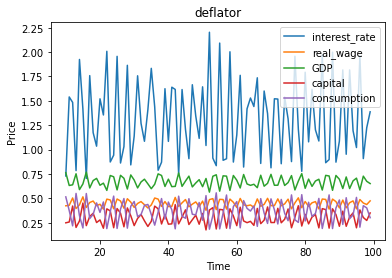

In [59]:
dataandfig(delta=.5,name="point5",t=100)

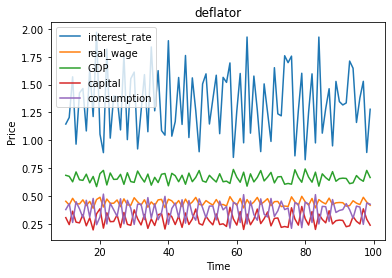

In [60]:
dataandfig(delta=0,name="zero",t=100)

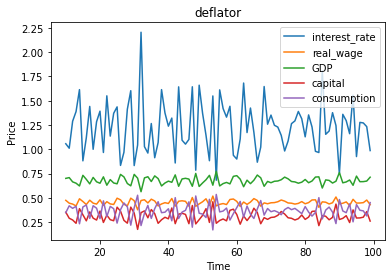

In [61]:
dataandfig(delta=.9,name="point9",t=100)

## next steps

variance in interest_rate:
    how does it vary with delta and H
    aggregate over runs

1) Run this code, tell us the outcome (commit to GitHub)

2) make a list of all variances and correlations of interest, modify this code to collect those


In [78]:
t=100

for thisH in np.linspace(0,10,11):
    for thisdelta in np.linspace(0,1,11):
        thesestats=[]
        for runs in range(100):
            dat=runmodel( delta=thisdelta , H=thisH, verbose=False,t=t)
            thisdat=dat[10:t]
            thesestats.append(statistics.variance(thisdat["interest_rate"]))
#            for col in thisdat.columns:
#                thesestats.append(statistics.variance(thisdat[col])
        avg_interestrate_var=statistics.mean(thesestats)
        print("delta", thisdelta, "H", thisH, ": ", avg_interestrate_var)

KeyboardInterrupt: 

In [63]:
print(np.linspace(0,1,11))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [76]:
statistics.mean(np.linspace(0,1,11))

0.5